In [40]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Embedding, GRU, Dense
from keras.layers import Embedding, Bidirectional, GRU, Dense


In [2]:
df = pd.read_csv('/kaggle/input/cleaned-welfake/cleaned_welfake.csv')

In [3]:
df.head(3)

,Unnamed: 0,title,text,label,total_content
0,0,law enforcement high alert following threat co...,comment member movement hanging white people c...,1,law enforcement high alert following threat co...
1,2,unbelievable attorney general say rioter peace...,demonstrator last night constitutional right p...,1,unbelievable attorney general say rioter peace...
2,3,bobby raised us story conversion woo potential...,dozen politically active pastor came private d...,0,bobby raised us story conversion woo potential...


In [4]:
df = df.dropna()

In [5]:
df = df.drop(['title','Unnamed: 0','text'], axis=1)

In [6]:
df.head(3)

,label,total_content
0,1,law enforcement high alert following threat co...
1,1,unbelievable attorney general say rioter peace...
2,0,bobby raised us story conversion woo potential...


In [7]:
df.rename(columns = {'total_content':'text'}, inplace = True)

In [8]:
df.head(3)

,label,text
0,1,law enforcement high alert following threat co...
1,1,unbelievable attorney general say rioter peace...
2,0,bobby raised us story conversion woo potential...


In [9]:
# Spliting the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [10]:
# Separating the text and label columns in each set
train_texts = train_df['text'].values
train_labels = train_df['label'].values
val_texts = val_df['text'].values
val_labels = val_df['label'].values
test_texts = test_df['text'].values
test_labels = test_df['label'].values

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [12]:
# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [13]:
max_sequence_length = max(len(seq) for seq in train_sequences)
print(max_sequence_length)

8703


In [14]:
max_sequence_length = 300  # Adjust this value according to your data

In [15]:
# Pad sequences to have a fixed length
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [16]:
# Load pre-trained GloVe embeddings
embedding_dim = 300  # Adjust this value based on the dimension of the GloVe embeddings you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

In [17]:
glove_file = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'  # Replace with the path to your GloVe file
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [41]:
# Model architecture
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Bidirectional(GRU(128)))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          10453200  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,783,697
Trainable params: 330,497
Non-trainable params: 10,453,200
_________________________________________________________________


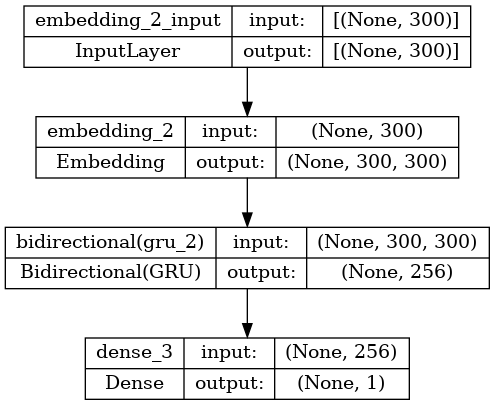

In [42]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [44]:
# Model training
batch_size = 64
epochs = 20

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [46]:
model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/20
705/705 [==============================] - 42s 55ms/step - loss: 0.2597 - accuracy: 0.8931 - val_loss: 0.1779 - val_accuracy: 0.9317
Epoch 2/20
705/705 [==============================] - 35s 50ms/step - loss: 0.1460 - accuracy: 0.9447 - val_loss: 0.1359 - val_accuracy: 0.9501
Epoch 3/20
705/705 [==============================] - 36s 51ms/step - loss: 0.0988 - accuracy: 0.9635 - val_loss: 0.1231 - val_accuracy: 0.9561
Epoch 4/20
705/705 [==============================] - 36s 51ms/step - loss: 0.0613 - accuracy: 0.9784 - val_loss: 0.1217 - val_accuracy: 0.9573
Epoch 5/20
705/705 [==============================] - 36s 51ms/step - loss: 0.0306 - accuracy: 0.9899 - val_loss: 0.1421 - val_accuracy: 0.9558
Epoch 6/20
705/705 [==============================] - 36s 51ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.1842 - val_accuracy: 0.9533
Epoch 7/20
705/705 [==============================] - 36s 51ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.1732 - val_accuracy:

In [35]:
# Model evaluation
loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

441/441 [==============================] - 5s 12ms/step - loss: 0.1277 - accuracy: 0.9557
Test Loss: 0.1277
Test Accuracy: 0.9557


In [36]:
# Perform predictions on the test set
test_predictions = model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int)

441/441 [==============================] - 5s 10ms/step


In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [38]:
# Calculate precision, recall, and F1-score
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1score = f1_score(test_labels, test_predictions)

In [39]:
# Print the metrics
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1score)

Precision: 0.960195530726257
Recall: 0.9530080399223732
F1-Score: 0.9565882844023933
